In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h


In [2]:
h.load_file('stdrun.hoc')

1.0

In [3]:
class Synapse:
    def __init__(self, sect, loc, tau1, tau2, e):
        self.syn                = h.MyExp2SynBB(loc, sec=sect)
        self.syn.tau1   = tau1
        self.syn.tau2   = tau2
        self.syn.e              = e

class SynapseNMDA:
    def __init__(self, sect, loc, tau1, tau2, tau1NMDA, tau2NMDA, r, e):
        self.syn                        = h.MyExp2SynNMDABB(loc, sec=sect)
        self.syn.tau1           = tau1
        self.syn.tau2           = tau2
        self.syn.tau1NMDA       = tau1NMDA
        self.syn.tau2NMDA       = tau2NMDA
        self.syn.r                      = r
        self.syn.e                      = e


In [4]:
class Cell:
    "General cell"

    def __init__(self,x,y,z,id):
        self.x=x
        self.y=y
        self.z=z
        self.id=id
        self.all_sec = []
        self.add_comp('soma',True)
        self.set_morphology()
        self.set_conductances()
        self.set_synapses()
        self.set_inj(0.9, 10, 2000)
        self.calc_area()

    def set_morphology(self):
        pass

    def set_conductances(self):
        pass

    def set_synapses(self):
        pass

    def set_inj(self, dc, dur, delay):
        self.somaInj = h.IClamp(dc, sec=self.soma)
        self.somaInj.dur = dur
        self.somaInj.dur = delay

    def add_comp(self, name, rec):
        self.__dict__[name] = h.Section()
        self.all_sec.append(self.__dict__[name])
        # Record voltage
        if rec:
            self.__dict__[name+"_volt"] = h.Vector(int(h.tstop/h.dt)+1)
            self.__dict__[name+"_volt"].record(self.__dict__[name](0.5)._ref_v)

    def plot_volt(self, name, fig=1):
        plt.figure(fig)
        volt = self.__dict__[name+"_volt"].to_python()
        plt.plot(np.arange(len(volt))*h.dt, volt)

    def calc_area(self):
        self.total_area = 0
        self.n = 0
        for sect in self.all_sec:
            self.total_area += h.area(0.5,sec=sect)
            self.n+=1


In [5]:
###############################################################################
#
# Basket Cell -- Bwb
#
###############################################################################

class Bwb(Cell):
    "Basket cell"

    def set_morphology(self):
        total_area = 10000 # um2
        self.soma.nseg  = 1
        self.soma.cm    = 1      # uF/cm2
        diam = np.sqrt(total_area) # um
        L    = diam/np.pi  # um

        h.pt3dclear(sec=self.soma)
        h.pt3dadd(self.x, self.y, self.z,   diam, sec=self.soma)
        h.pt3dadd(self.x, self.y, self.z+L, diam, sec=self.soma)

    def set_conductances(self):
        self.soma.insert('pas')
        self.soma.e_pas = -65     # mV
        self.soma.g_pas = 0.1e-3  # S/cm2

        self.soma.insert('Nafbwb')
        self.soma.insert('Kdrbwb')

    def set_synapses(self):
        self.somaAMPAf  = Synapse(sect=self.soma, loc=0.5, tau1=0.05, tau2=5.3, e=0)
        self.somaGABAf  = Synapse(sect=self.soma, loc=0.5, tau1=0.07, tau2=9.1, e=-80)
        self.somaGABAss = Synapse(sect=self.soma, loc=0.5, tau1=20,   tau2=40, e=-80)#only for septal input
        self.somaNMDA   = SynapseNMDA(sect=self.soma, loc=0.5, tau1=0.05, tau2=5.3, tau1NMDA=15, tau2NMDA=150, r=1, e=0)

In [6]:
###############################################################################
#
# OLM Cell -- Ow
#
###############################################################################
class Ow(Cell):
    "OLM cell"

    def set_morphology(self):
        total_area = 10000 # um2
        self.soma.nseg  = 1
        self.soma.cm    = 1      # uF/cm2
        diam = np.sqrt(total_area) # um
        L    = diam/np.pi  # um

        h.pt3dclear(sec=self.soma)
        h.pt3dadd(self.x, self.y, self.z,   diam, sec=self.soma)
        h.pt3dadd(self.x, self.y, self.z+L, diam, sec=self.soma)

    def set_conductances(self):
        self.soma.insert('pas')
        self.soma.e_pas = -65     # mV
        self.soma.g_pas = 0.1e-3  # S/cm2

        self.soma.insert('Nafbwb')
        self.soma.insert('Kdrbwb')

        self.soma.insert('Iholmw')
        self.soma.insert('Caolmw')
        self.soma.insert('ICaolmw')
        self.soma.insert('KCaolmw')

    def set_synapses(self):
        self.somaGABAf  = Synapse(sect=self.soma, loc=0.5, tau1=0.07, tau2=9.1, e=-80)
        self.somaAMPAf  = Synapse(    sect=self.soma, loc=0.5, tau1=0.05, tau2=5.3, e=0)
        self.somaGABAss = Synapse(    sect=self.soma, loc=0.5, tau1=20,   tau2=40, e=-80)#only for septal input
        self.somaNMDA   = SynapseNMDA(sect=self.soma, loc=0.5, tau1=0.05, tau2=5.3, tau1NMDA=15, tau2NMDA=150, r=1, e=0)

In [7]:
###############################################################################
#
# Pyramidal Cell -- KopAdr
#
###############################################################################
class PyrAdr(Cell):
    "Pyramidal cell"

    def set_morphology(self):
        self.add_comp('Bdend',True)
        self.add_comp('Adend1',False)
        self.add_comp('Adend2',False)
        self.add_comp('Adend3',True)

        h.pt3dclear(sec=self.soma)
        h.pt3dadd(self.x, self.y, self.z,          20, sec=self.soma)
        h.pt3dadd(self.x, self.y, self.z+20,       20, sec=self.soma)

        h.pt3dclear(sec=self.Bdend)
        h.pt3dadd(self.x, self.y, self.z,          2, sec=self.Bdend)
        h.pt3dadd(self.x, self.y, self.z-200,      2, sec=self.Bdend)

        h.pt3dclear(sec=self.Adend1)
        h.pt3dadd(self.x, self.y, self.z+20,       2, sec=self.Adend1)
        h.pt3dadd(self.x, self.y, self.z+20+150,   2, sec=self.Adend1)

        h.pt3dclear(sec=self.Adend2)
        h.pt3dadd(self.x, self.y, self.z+20+150,   2, sec=self.Adend2)
        h.pt3dadd(self.x, self.y, self.z+20+150*2, 2, sec=self.Adend2)

        h.pt3dclear(sec=self.Adend3)
        h.pt3dadd(self.x, self.y, self.z+20+150*2, 2, sec=self.Adend3)
        h.pt3dadd(self.x, self.y, self.z+20+150*3, 2, sec=self.Adend3)

        self.Bdend.connect(self.soma,      0, 0)
        self.Adend1.connect(self.soma,   0.5, 0)
        self.Adend2.connect(self.Adend1,   1, 0)
        self.Adend3.connect(self.Adend2,   1, 0)

    def set_conductances(self):
        for sect in self.all_sec:
            sect.insert('pas')
            sect(0.5).pas.g = 0.0000357
            sect.insert('nacurrent')
            sect.insert('kacurrent')
            sect.insert('kdrcurrent')
            sect.insert('hcurrent')
            sect(0.5).pas.e = -70     # mV
            sect.cm = 1
            sect.Ra = 150

        self.Adend1(0.5).nacurrent.ki = 0.5
        self.Adend1(0.5).kacurrent.g  = 0.072
        self.Adend1(0.5).hcurrent.v50 = -82
        self.Adend1(0.5).hcurrent.g   = 0.0002

        self.Adend2(0.5).nacurrent.ki = 0.5
        self.Adend2(0.5).kacurrent.g  = 0
        self.Adend2(0.5).kacurrent.gd = 0.120
        self.Adend2(0.5).hcurrent.v50 = -90
        self.Adend2(0.5).hcurrent.g   = 0.0004

        self.Adend3(0.5).cm           = 2
        self.Adend3(0.5).pas.g        = 0.0000714
        self.Adend3(0.5).nacurrent.ki = 0.5
        self.Adend3(0.5).kacurrent.g  = 0
        self.Adend3(0.5).kacurrent.gd = 0.200
        self.Adend3(0.5).hcurrent.v50 = -90
        self.Adend3(0.5).hcurrent.g   = 0.0007

        self.Bdend(0.5).nacurrent.ki  = 1

    def set_synapses(self):
        self.somaGABAf   = Synapse(    sect=self.soma,   loc=0.5, tau1=0.07, tau2=9.1,    e=-80)
        self.somaAMPAf   = Synapse(    sect=self.soma,   loc=0.5, tau1=0.05, tau2=5.3,     e=0)
        self.BdendAMPA   = Synapse(    sect=self.Bdend,  loc=1.0, tau1=0.05, tau2=5.3,     e=0)
        self.BdendNMDA   = SynapseNMDA(sect=self.Bdend,  loc=1.0, tau1=0.05, tau2=5.3, tau1NMDA=15, tau2NMDA=150, r=1, e=0)
        self.Adend2GABAs = Synapse(        sect=self.Adend2, loc=0.5, tau1=0.2,  tau2=20,   e=-80)
        self.Adend3GABAf = Synapse(        sect=self.Adend3, loc=0.5, tau1=0.07, tau2=9.1,   e=-80)
        self.Adend3AMPAf = Synapse(        sect=self.Adend3, loc=0.5, tau1=0.05, tau2=5.3,    e=0)
        self.Adend3NMDA  = SynapseNMDA(sect=self.Adend3, loc=0.5, tau1=0.05, tau2=5.3, tau1NMDA=15, tau2NMDA=150, r=1, e=0)

In [8]:
h.tstop = 5000
h.dt = 0.025


In [9]:
my_cell = PyrAdr(1,0,0,0)

In [10]:
my_cell.soma.L


20.0

In [11]:
v_vec = h.Vector()             # Membrane potential vector
t_vec = h.Vector()             # Time stamp vector
v_vec.record(my_cell.soma(0.5)._ref_v)
t_vec.record(h._ref_t)

Vector[4]

In [12]:
# l_dc = np.arange(0.0,1.0,0.1)
# for dc in l_dc:
#     my_cell.set_inj(dc,1000, 2000)
#     h.finitialize(1000.0)
#     h.run()
#     plt.figure(figsize=(8,4))
#     plt.plot(t_vec, v_vec)

In [13]:
my_cell.soma.psection()

{'point_processes': {'IClamp': {IClamp[0]},
  'MyExp2SynBB': {MyExp2SynBB[0], MyExp2SynBB[1]}},
 'density_mechs': {'pas': {'g': [3.57e-05], 'e': [-70.0], 'i': [0.0]},
  'hcurrent': {'g': [0.0001],
   'e': [-30.0],
   'v50': [-82.0],
   'gfactor': [1.0],
   'ih': [0.0],
   'hinf': [0.0],
   'htau': [0.0],
   'h': [0.0]},
  'kacurrent': {'g': [0.048],
   'gd': [0.0],
   'e': [-90.0],
   'ika': [0.0],
   'ikad': [0.0],
   'ninf': [0.0],
   'ntau': [0.0],
   'ndinf': [0.0],
   'ndtau': [0.0],
   'linf': [0.0],
   'ltau': [0.0],
   'n': [0.0],
   'nd': [0.0],
   'l': [0.0]},
  'kdrcurrent': {'g': [0.01],
   'e': [-90.0],
   'ik': [0.0],
   'ninf': [0.0],
   'ntau': [0.0],
   'n': [0.0]},
  'nacurrent': {'g': [0.032],
   'e': [55.0],
   'vi': [-60.0],
   'ki': [0.8],
   'ina': [0.0],
   'minf': [0.0],
   'mtau': [0.0],
   'hinf': [0.0],
   'htau': [0.0],
   'iinf': [0.0],
   'itau': [0.0],
   'm': [0.0],
   'h': [0.0],
   'I': [0.0]}},
 'ions': {},
 'morphology': {'L': 20.0,
  'diam': [20.0]

In [14]:
my_cell.__dict__

{'x': 1,
 'y': 0,
 'z': 0,
 'id': 0,
 'all_sec': [__nrnsec_0000024cae5a0550,
  __nrnsec_0000024cae5a05b0,
  __nrnsec_0000024cae5a0610,
  __nrnsec_0000024cae5a0670,
  __nrnsec_0000024cae5a06d0],
 'soma': __nrnsec_0000024cae5a0550,
 'soma_volt': Vector[0],
 'Bdend': __nrnsec_0000024cae5a05b0,
 'Bdend_volt': Vector[1],
 'Adend1': __nrnsec_0000024cae5a0610,
 'Adend2': __nrnsec_0000024cae5a0670,
 'Adend3': __nrnsec_0000024cae5a06d0,
 'Adend3_volt': Vector[2],
 'somaGABAf': <__main__.Synapse at 0x24cadf61890>,
 'somaAMPAf': <__main__.Synapse at 0x24cae0626d0>,
 'BdendAMPA': <__main__.Synapse at 0x24cae063b50>,
 'BdendNMDA': <__main__.SynapseNMDA at 0x24cae0631d0>,
 'Adend2GABAs': <__main__.Synapse at 0x24cadb8d550>,
 'Adend3GABAf': <__main__.Synapse at 0x24cadcb0550>,
 'Adend3AMPAf': <__main__.Synapse at 0x24cae063550>,
 'Adend3NMDA': <__main__.SynapseNMDA at 0x24cae063910>,
 'somaInj': IClamp[0],
 'total_area': 5340.707511102649,
 'n': 5}

In [15]:
simdur = 5000
time_limit = simdur

In [16]:
ns = h.NetStim()
ISI = 1
ns.interval = ISI
ns.noise = 1
ns.number = (1e3 / ISI) * time_limit
ns.start = 0
w=0.012e-3
nc = h.NetCon(ns,my_cell.__dict__["Adend3GABAf"].syn)
nc.delay = h.dt * 2 # 0
nc.weight[0] = w

In [17]:
ns = h.NetStim()
ISI = 1
ns.interval = ISI
ns.noise = 1
ns.number = (1e3 / ISI) * time_limit
ns.start = 0
w=0.05e-3
nc = h.NetCon(ns,my_cell.__dict__["Adend3AMPAf"].syn)
nc.delay = h.dt * 2 # 0
nc.weight[0] = w

In [18]:
ns = h.NetStim()
ISI = 100
ns.interval = ISI
ns.noise = 1
ns.number = (1e3 / ISI) * time_limit
ns.start = 0
w=6.5e-3
nc = h.NetCon(ns,my_cell.__dict__["Adend3NMDA"].syn)
nc.delay = h.dt * 2 # 0
nc.weight[0] = w

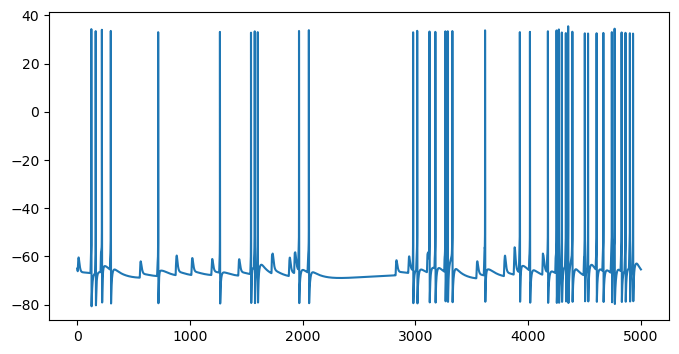

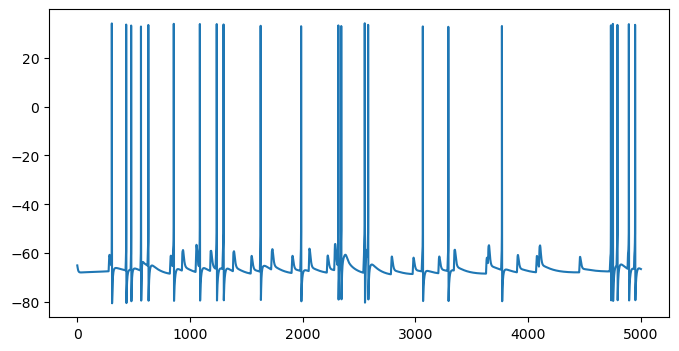

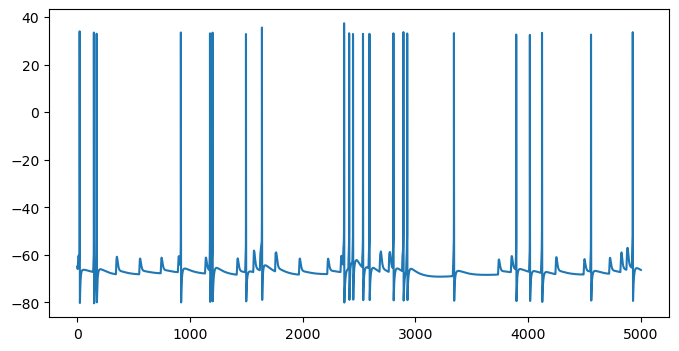

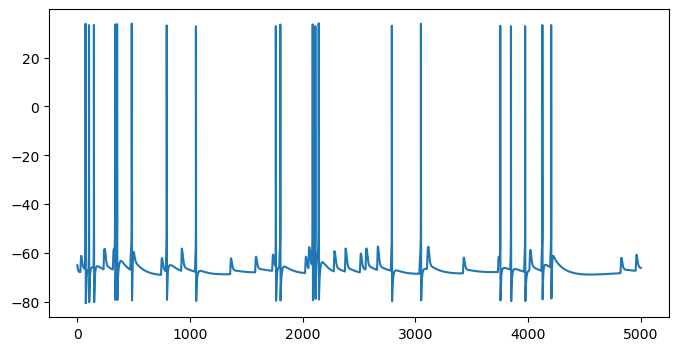

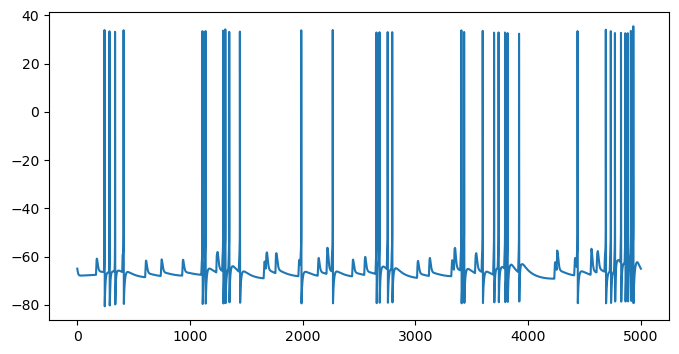

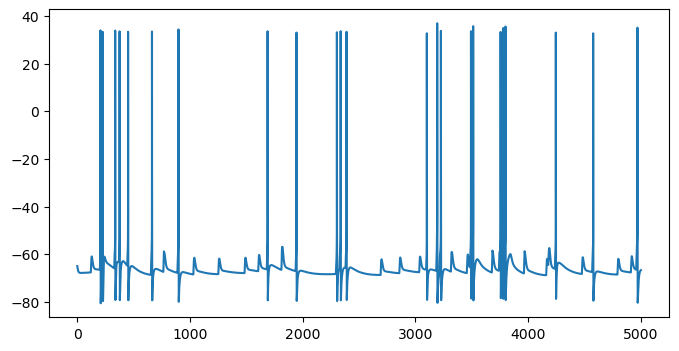

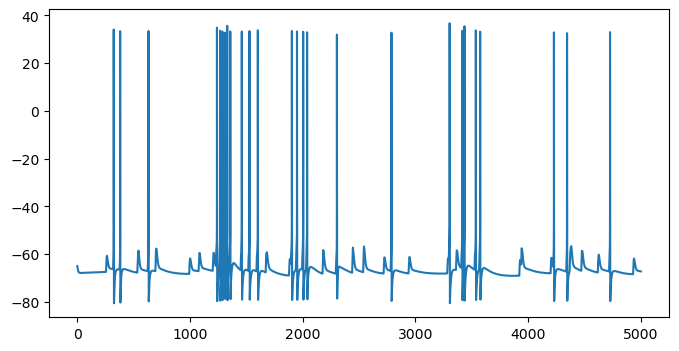

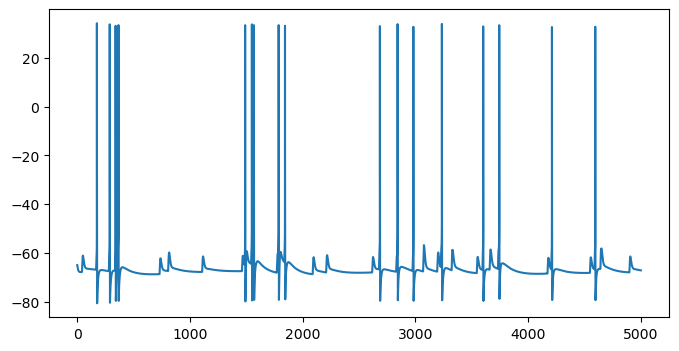

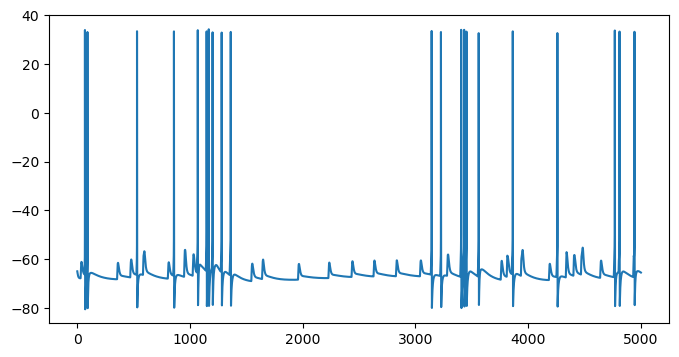

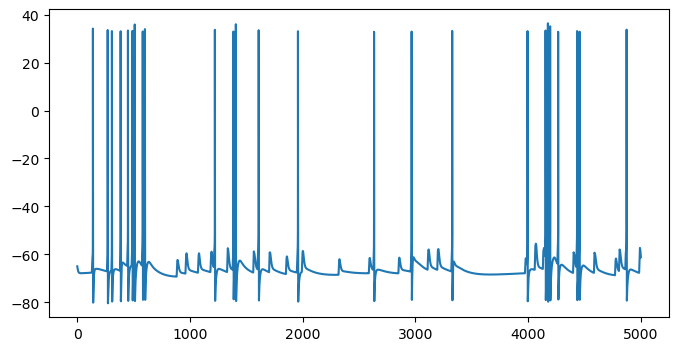

In [19]:
l_dc = np.arange(0.0,1.0,0.1)
for dc in l_dc:
    my_cell.set_inj(dc,1000, 2000)
    h.finitialize(1000.0)
    h.run()
    plt.figure(figsize=(8,4))
    plt.plot(t_vec, v_vec)